In [201]:
import pandas as pd
import numpy as np
from gurobipy import *  
import gurobipy as gp
from gurobipy import GRB
from array import *
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import stats
import seaborn as sns
import statistics
from scipy.stats import norm

In [202]:
# Required Functions for preparing indices to denote powerfloes and generators
def merge3(list1, list2, list3):
      
    merged_list = [(list1[i], list2[i], list3[i]) for i in range(0, len(list1))]
    return merged_list

def merge(list1, list2):
      
    merged_list = [(list1[i], list2[i]) for i in range(0, len(list1))]
    return merged_list


def array_list(array_num):
    num_list = array_num.tolist() # list
    print(num_list)





In [203]:
#Reading the bus, branch and generators data files
branches_file = pd.read_csv("/Users/rishabhsalwan/Desktop/1814/branches.csv")
#Removing the end cell from the data frame 
branches_file.drop(labels=[len(branches_file)-1],axis=0,inplace=True)

buses_file = pd.read_csv("/Users/rishabhsalwan/Desktop/1814/buses.csv")
buses_file.drop(labels=[len(buses_file)-1],axis=0,inplace=True)

generators_file = pd.read_csv("/Users/rishabhsalwan/Desktop/1814/generators.csv")
generators_file.drop(labels=[len(generators_file)-1],axis=0,inplace=True)


In [204]:
# data Pre-processing

#Reading the from bus
branches_file["from"] = list(branches_file['from'].astype(int))
#Reading the to bus
branches_file["to"] = list(branches_file['to'].astype(int))
frm = branches_file["from"]
to = branches_file["to"]
#Reading bus numbers
buses = list(buses_file['bus'].astype(int))
#Reading branch numbers
branches = list(branches_file['branch'].astype(int))
#Creating an index for denoting power flows(branch,from,to)
flows = list(merge3(branches,frm,to))

#list of buses from generators file
bus_gen = list(generators_file['bus'].astype(int))
#list of generators from generators file
gen_gen = list(generators_file['generator'].astype(int))
#Creating an index for generators as (generator, bus)
generators = list(merge(gen_gen,bus_gen))

#Initializing all the required variables
d = dict(zip(buses,buses_file[" load"]))
x = dict(zip(flows,branches_file["x"]))
u = dict(zip(flows,branches_file["u"]))
pmax = dict(zip(generators,generators_file["pmax"]))
sig = dict(zip(generators,generators_file["sigma"]))

In [205]:
#Create Model
m = gp.Model("Real_Energy_Markets")

In [206]:
#Decision Variables
power_gen = m.addVars(generators, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'), name="Pg")
power_flow = m.addVars(flows, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'), name="Pf")
Theta = m.addVars(buses, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'),name="Theta")
Shed = m.addVars(buses, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'),name="Shed")

In [207]:
#Constraints
#Balance
m.addConstrs((power_flow.sum('*',i,"*") - power_flow.sum("*","*",i) - power_gen.sum("*",i) - Shed[i] ==  - d[i] for i in buses), name="Flow_conservation")
#Power Flow and Capacity
m.addConstrs((power_flow[i] - (1/x[i])*Theta[i[1]] + (1/x[i])*Theta[i[2]] == 0 for i in flows), name="Power Flow")
m.addConstrs((power_flow[a] <= u[a] for a in flows), name="Power limit")
m.addConstrs((power_flow[a] >= -u[a] for a in flows), name="Power limit")
# Shed
m.addConstrs((Shed[v] <= d[v] for v in buses), name="Shed limit")
# Power
m.addConstrs((power_gen[v] <= pmax[v] for v in generators), name="Power Generation limit")

{(0, 10): <gurobi.Constr *Awaiting Model Update*>,
 (1, 11): <gurobi.Constr *Awaiting Model Update*>,
 (2, 12): <gurobi.Constr *Awaiting Model Update*>,
 (3, 12): <gurobi.Constr *Awaiting Model Update*>,
 (4, 13): <gurobi.Constr *Awaiting Model Update*>,
 (5, 14): <gurobi.Constr *Awaiting Model Update*>,
 (6, 15): <gurobi.Constr *Awaiting Model Update*>,
 (7, 16): <gurobi.Constr *Awaiting Model Update*>,
 (8, 16): <gurobi.Constr *Awaiting Model Update*>,
 (9, 17): <gurobi.Constr *Awaiting Model Update*>,
 (10, 17): <gurobi.Constr *Awaiting Model Update*>,
 (11, 18): <gurobi.Constr *Awaiting Model Update*>,
 (12, 18): <gurobi.Constr *Awaiting Model Update*>,
 (13, 19): <gurobi.Constr *Awaiting Model Update*>,
 (14, 20): <gurobi.Constr *Awaiting Model Update*>,
 (15, 20): <gurobi.Constr *Awaiting Model Update*>,
 (16, 20): <gurobi.Constr *Awaiting Model Update*>,
 (17, 20): <gurobi.Constr *Awaiting Model Update*>,
 (18, 20): <gurobi.Constr *Awaiting Model Update*>,
 (19, 20): <gurobi.Con

In [208]:
# Objective
m.setObjective(quicksum(power_gen[e]*sig[e] for e in generators) +  quicksum(1000000*Shed[e] for e in buses), GRB.MINIMIZE)

In [209]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc658a087
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3677 columns
Presolve time: 0.05s
Presolved: 1131 rows, 2549 columns, 6848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     972    6.0858309e+05   0.000000e+00   0.000000e+00      0s

Solved in 972 iterations and 0.29 seconds
Optimal objective  6.085830856e+05


In [213]:
# Creating a vector for all the power generation values based on optimization
pg1 = []
for v in power_gen.values():
    pg1.append(v.X)

In [214]:
# getting duals for power balance and converting to pi
#Initializing an empty variable for dual values
dual = []

#loop for creating a vector of dual values for all power balance constraints
for c in m.getConstrs():
    dual.append(c.pi)
    
# Converting dual vector into an array for ease of computation
dual = np.array(dual[0:1814])

#Getting the pi vector which is -dual
pi = - dual
#A dictionary containing each pi value corresponding to its bus
pi = dict(zip(buses, pi))

# Initialising an empty shed vector
Shed_vec = []
# Running a loop to get a vector with all the shed values
for v in Shed.values():
    Shed_vec.append(v.X)

#Creating a dictionary of shed values with corresponding buses
Shed_vec = dict(zip(buses, Shed_vec))

# Calculating cost based on pi, shed, and load(d) for all the buses
cost = quicksum(pi[i]*d[i] - pi[i]*Shed_vec[i] for i in buses)

#extracting the value of initial cost(Cost for 1st problem)
initial_cost = cost.getValue()

In [215]:
#Get pmax mean value for wind generators
#Grouping all the generators based on type of fuel and getting mean of each
fuel_mean = np.array([generators_file.groupby("fuel").mean()])
#Extracting the mean value for wind generators
pmax_mean = fuel_mean[0][6][1]

In [169]:
#Variance table was created only using the covariance values for wind generators 362, 363, 364,...394
variance_table = pd.read_excel("/Users/rishabhsalwan/Downloads/new covariance.xlsx")
#Converting to an array for computation
variance = np.array([variance_table])
#Getting standard deveiation as a square root of variance
std = np.sqrt(variance)

In [216]:
# Loop Starts here
# Creating a cost vector to contain 1000 cost values, one for each iteration
cost_vec = []
# setting the counter for the loop
l = 1
# for loop for 1000 iterations and simuulation
for l in range(1000):
    # i is the counter for generating 33 pmax values for wind generators
    i = 0
    # r is the vector containing all 33 pmax values
    r = []
    # loop to get r vector with 33 pmax values
    for i in range(33):
        # pmax value is a random variable with a normal distribution having mean as mean of pmax and standard deviation
        # from the 33 standard deviation values computed above
        r.append(np.random.normal(pmax_mean, std[0][i]))
        i = i + 1

    # Convert r to an array for computations
    r = np.array(r)
    # Power generated cannot take negative values, therefore, using absolute values
    r = abs(r)
    # Converting r from array to list
    r = r.tolist()
    # Cleaning up the format of r list to get b, same as r but in a more desireable format
    b=[]
    for row in r:
        b += row
    # Extracting power generation values for each generator from the last optimization run and using as vector pg
    pg = []
    for v in power_gen.values():
        pg.append(v.X)
    
    #replacing the power generation values in pg for the wind generators with those obtained from random generation
    pg[362:395] = b

    # Creating the new Power generation dictionary & incdices for new LP
    #power_gen_wind is a dictionary with the power generation values listed corresponding to their generators
    power_gen_wind = dict(zip(generators,pg))
    
    # Extracting a list only for wind generators from the one above, this has wind power generation indexed with generators indices
    mydict = power_gen_wind
    power_wind = []
    for x in list(reversed(list(mydict.items())))[0:33]:
        power_wind.append(x)
    # Converting the list of wind generators obtained to a dictionary with indices
    power_wind = dict(power_wind)
    # Further extracting the indexes of wind generators only, to be used in settinf constraints specifically for them
    gen_wind = power_wind.keys()
    # Converting to a list
    gen_wind = list(gen_wind)
    
    # Extracting a list only for non-wind generators, this has non-wind power generation indexed with generators indices
    mydict = generators
    # Vector to contain indices of non-wind generators
    gen_other = []
    for x in list(mydict)[0:362]:
        gen_other.append(x)
    # Converting the vector of indices to a list
    gen_other = list(gen_other)
    
    # Creating new model
    m1 = gp.Model("Real_Energy_Markets")
    # Initialising variables
    d = dict(zip(buses,buses_file[" load"]))
    x = dict(zip(flows,branches_file["x"]))
    u = dict(zip(flows,branches_file["u"]))
    pmax = dict(zip(generators,generators_file["pmax"]))
    sig = dict(zip(generators,generators_file["sigma"]))


    #Decision Variables
    power_gen_new = m1.addVars(generators, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'), name="Pg")
    power_flow_new = m1.addVars(flows, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'), name="Pf")
    Theta_new = m1.addVars(buses, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'),name="Theta")
    Shed_new = m1.addVars(buses, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'),name="Shed")

    #Constraints
    #Balance
    m1.addConstrs((power_flow_new.sum('*',i,"*") - power_flow_new.sum("*","*",i) - power_gen_new.sum("*",i) - Shed_new[i] ==  - d[i] for i in buses), name="Flow_conservation")
    #Power Flow and Capacity
    m1.addConstrs((power_flow_new[i] - (1/x[i])*Theta_new[i[1]] + (1/x[i])*Theta_new[i[2]] == 0 for i in flows), name="Power Flow")
    m1.addConstrs((power_flow_new[a] <= u[a] for a in flows), name="Power limit")
    m1.addConstrs((power_flow_new[a] >= -u[a] for a in flows), name="Power limit")
    # Shed
    m1.addConstrs((Shed_new[v] <= d[v] for v in buses), name="Shed limit")
    # Power
    # Setting the power for wind generators as obtained from simulation
    m1.addConstrs((power_gen_new[v] == power_wind[v] for v in gen_wind), name="Power Generation limit")
    # Setting the same constraint for all other generators
    m1.addConstrs((power_gen_new[v] <= pmax[v] for v in gen_other), name="Power Generation limit")

    # Objective
    m1.setObjective(quicksum(power_gen_new[e]*sig[e] for e in generators) +  quicksum(1000000*Shed_new[e] for e in buses), GRB.MINIMIZE)
    # Optimize
    m1.optimize()
    
    # Getting duals for each power balance constraint
    dual = []
    for c in m1.getConstrs():
        dual.append(c.pi)
    
    dual = np.array(dual[0:1814])
    # Determining pi values from the dual
    pi = - dual
    pi = dict(zip(buses, pi))
    
    # Making a vector of minimised Shed Values obtained as a result of optimization
    Shed_vec = []
    for v in Shed_new.values():
        Shed_vec.append(v.X)

    Shed_vec = dict(zip(buses, Shed_vec))

    # Calculating cost using shed value, pi and load
    cost = quicksum(pi[i]*d[i] - pi[i]*Shed_vec[i] for i in buses)
    # Appending the cost obtained from each run to the 1000 cost vector initialised above
    cost_vec.append(cost.getValue())
    # Counter for 1000 runs
    l = l+1

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf4a065b6
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     964    5.4933692e+05   0.000000e+00   0.000000e+00      0s

Solved in 964 iterations and 0.21 seconds
Optimal objective  5.493369249e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x9779309e


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x040f9efe
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     985    5.5255333e+05   0.000000e+00   0.000000e+00      0s

Solved in 985 iterations and 0.22 seconds
Optimal objective  5.525533264e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x82dc4d15


    1028    5.5690562e+05   0.000000e+00   0.000000e+00      0s

Solved in 1028 iterations and 0.18 seconds
Optimal objective  5.569056221e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x524d7de8
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1067    5.5814957e+05   0.000000e+00   0.000000e+00      0s

Solved in 1067 iterations and 0.21 seconds
Optimal objective  5.581495662e+05
Gurobi Optimizer version 9.1.2 build v9.1

  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.05s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     991    5.5878740e+05   0.000000e+00   0.000000e+00      0s

Solved in 991 iterations and 0.28 seconds
Optimal objective  5.587873957e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf832dd9b
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.08s
Presolved: 1131 ro

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe5c8a706
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     963    5.5596620e+05   0.000000e+00   0.000000e+00      0s

Solved in 963 iterations and 0.17 seconds
Optimal objective  5.559661954e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x10c69c35
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+0

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x81f2f82d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1085    5.5670811e+05   0.000000e+00   0.000000e+00      0s

Solved in 1085 iterations and 0.19 seconds
Optimal objective  5.567081130e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5c5fb230
Coefficient statistics:
  Matrix range     [1e+00, 2e+

Optimal objective  5.520554039e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe5a0d4c3
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1036    5.5681038e+05   0.000000e+00   0.000000e+00      0s

Solved in 1036 iterations and 0.19 seconds
Optimal objective  5.568103759e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model w

Optimal objective  5.549434050e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xfea04f70
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     956    5.5303800e+05   0.000000e+00   0.000000e+00      0s

Solved in 956 iterations and 0.14 seconds
Optimal objective  5.530380008e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonz

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x35c736be
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     982    5.5592159e+05   0.000000e+00   0.000000e+00      0s

Solved in 982 iterations and 0.21 seconds
Optimal objective  5.559215867e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x9f53e045
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+0

Model fingerprint: 0xe006ce34
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     987    5.5354521e+05   0.000000e+00   0.000000e+00      0s

Solved in 987 iterations and 0.17 seconds
Optimal objective  5.535452127e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5b36ea42
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3700 c

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc4374ced
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1080    5.5812814e+05   0.000000e+00   0.000000e+00      0s

Solved in 1080 iterations and 0.19 seconds
Optimal objective  5.581281407e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xdde0e653
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+

Model fingerprint: 0xef5b0372
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     968    5.5107274e+05   0.000000e+00   0.000000e+00      0s

Solved in 968 iterations and 0.17 seconds
Optimal objective  5.510727406e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x4dfd0c65
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 c

  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3704 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1089    5.5359077e+05   0.000000e+00   0.000000e+00      0s

Solved in 1089 iterations and 0.25 seconds
Optimal objective  5.535907720e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x751be502
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3702 columns
Presolve time: 0.03s
Presolved: 1129 rows, 252


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1203 iterations and 0.17 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc824d20e
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3702 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2524 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 994 iterations and 0.18 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x00e63b0c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1077    5.5633211e+05   0.000000e+00   0.000000e+00      0s

Solved in 1077 iterations and 0.18 seconds
Optimal objective  5.563321136e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x31a566c6
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2527 columns, 6827 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     940    5.5491414e+05   0.000000e+00   0.000000e+00      0s

Solved in 940 iterations and 0.16 seconds
Optimal objective  5.549141359e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc3abdaca
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf65e72bb
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1012    5.5313461e+05   0.000000e+00   0.000000e+00      0s

Solved in 1012 iterations and 0.21 seconds
Optimal objective  5.531346120e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5af9f21a
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH

Optimal objective  5.604935759e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5068befa
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3706 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2520 columns, 6817 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1009    5.5826652e+05   0.000000e+00   0.000000e+00      0s

Solved in 1009 iterations and 0.18 seconds
Optimal objective  5.582665183e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model w

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x24ea541f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2528 columns, 6829 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     968    5.5379813e+05   0.000000e+00   0.000000e+00      0s

Solved in 968 iterations and 0.16 seconds
Optimal objective  5.537981320e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe69f6424


Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0cd0d8e0
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9505 rows and 3706 columns
Presolve time: 0.04s
Presolved: 1127 rows, 2520 columns, 6816 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     962    5.5855955e+05   0.000000e+00   0.000000e+00      0s

Solved in 962 iterations and 0.20 seconds
Optimal objective  5.585595477e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xabd71690
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+0

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x79d56ef2
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1082    5.5515024e+05   0.000000e+00   0.000000e+00      0s

Solved in 1082 iterations and 0.19 seconds
Optimal objective  5.551502356e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3047a2f9
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH

Model fingerprint: 0x23ae5531
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 6
     927    5.5562948e+05   0.000000e+00   0.000000e+00      0s

Solved in 927 iterations and 0.16 seconds
Optimal objective  5.556294800e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x324cd2fa
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     965    5.5560166e+05   0.000000e+00   0.000000e+00      0s

Solved in 965 iterations and 0.16 seconds
Optimal objective  5.556016567e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x62794865
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2527 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     969    5.5684345e+05   0.000000e+00   0.000000e+00 

Model fingerprint: 0xd726568a
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1040    5.5682128e+05   0.000000e+00   0.000000e+00      0s

Solved in 1040 iterations and 0.21 seconds
Optimal objective  5.568212827e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe3ac2c36
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3703 

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xcc8dff7b
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     951    5.5471528e+05   0.000000e+00   0.000000e+00      0s

Solved in 951 iterations and 0.18 seconds
Optimal objective  5.547152816e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5c1a1064
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS

Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1069    5.5355628e+05   0.000000e+00   0.000000e+00      0s

Solved in 1069 iterations and 0.20 seconds
Optimal objective  5.535562841e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x78c5276f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9499 rows and 3696 columns
Presolve time: 0.03s
Presolved: 1133 rows, 2530 columns, 6832 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables           

Presolve time: 0.04s
Presolved: 1129 rows, 2524 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1022    5.5155635e+05   0.000000e+00   0.000000e+00      0s

Solved in 1022 iterations and 0.20 seconds
Optimal objective  5.515563521e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe26442ee
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1132 rows, 2528 columns, 6829 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations a

  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1016    5.5944704e+05   0.000000e+00   0.000000e+00      0s

Solved in 1016 iterations and 0.19 seconds
Optimal objective  5.594470410e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x72e6fa72
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    

Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     950    5.5923277e+05   0.000000e+00   0.000000e+00      0s

Solved in 950 iterations and 0.18 seconds
Optimal objective  5.592327746e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x212db8c9
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    10

Presolve removed 9503 rows and 3702 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2524 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1019    5.5514718e+05   0.000000e+00   0.000000e+00      0s

Solved in 1019 iterations and 0.21 seconds
Optimal objective  5.551471796e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf1749ce6
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-05, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.05s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2527 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     961    5.5177300e+05   0.000000e+00   0.000000e+00      0s

Solved in 961 iterations and 0.20 seconds
Optimal objective  5.517729998e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xd1133901
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.   

  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1031    5.5300270e+05   0.000000e+00   0.000000e+00      0s

Solved in 1031 iterations and 0.18 seconds
Optimal objective  5.530027011e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x21d7937e
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3701 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2525 columns, 6823 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1038    5.5969626e+05   0.000000e+00   0.000000e+00      0s

Solved in 1038 iterations and 0.18 seconds
Optimal objective  5.596962646e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xac4e9c93
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2527 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.  

Presolve time: 0.04s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     922    5.5782055e+05   0.000000e+00   0.000000e+00      0s

Solved in 922 iterations and 0.21 seconds
Optimal objective  5.578205493e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x5c333c8f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables              

Presolve time: 0.04s
Presolved: 1130 rows, 2527 columns, 6827 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1039 iterations and 0.18 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x237fceca
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     966    5.5722304e+05   0.000000e+00   0.000000e+00      0s

Solved in 966 iterations and 0.18 seconds
Op

    1044    5.5499626e+05   0.000000e+00   0.000000e+00      0s

Solved in 1044 iterations and 0.25 seconds
Optimal objective  5.549962602e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x41820d5d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     995    5.6132615e+05   0.000000e+00   0.000000e+00      0s

Solved in 995 iterations and 0.17 seconds
Optimal objective  5.613261507e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical core


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1089    5.5010080e+05   0.000000e+00   0.000000e+00      0s

Solved in 1089 iterations and 0.19 seconds
Optimal objective  5.501007969e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xb27f9ba2
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1057 iterations and 0.21 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build 

    1093    5.5829613e+05   0.000000e+00   0.000000e+00      0s

Solved in 1093 iterations and 0.21 seconds
Optimal objective  5.582961266e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x659a487d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1062    5.5379966e+05   0.000000e+00   0.000000e+00      0s

Solved in 1062 iterations and 0.20 seconds
Optimal objective  5.537996646e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cor

     987    5.5763255e+05   0.000000e+00   0.000000e+00      0s

Solved in 987 iterations and 0.19 seconds
Optimal objective  5.576325539e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x63e73678
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1274    5.5712679e+05   0.000000e+00   0.000000e+00      0s

Solved in 1274 iterations and 0.23 seconds
Optimal objective  5.571267913e+05
Gurobi Optimizer version 9.1.2 build v9.1.

Presolve time: 0.04s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1097    5.5763095e+05   0.000000e+00   0.000000e+00      0s

Solved in 1097 iterations and 0.22 seconds
Optimal objective  5.576309457e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x7c3090f7
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables             

Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1056    5.5066169e+05   0.000000e+00   0.000000e+00      0s

Solved in 1056 iterations and 0.23 seconds
Optimal objective  5.506616941e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xfd57cc73
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3702 columns
Presolve time: 0.04s
P

Model fingerprint: 0xa8a823f0
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3702 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2524 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1016    5.5702298e+05   0.000000e+00   0.000000e+00      0s

Solved in 1016 iterations and 0.19 seconds
Optimal objective  5.570229846e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xd91b4b74
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3700 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2526 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1025    5.5667129e+05   0.000000e+00   0.000000e+00      0s

Solved in 1025 iterations and 0.21 seconds
Optimal objective  5.566712909e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3ca300bd
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9499 rows and 3695 columns
Presolve time: 0.03s
Presolved: 1133 rows, 2531 columns, 6833 nonzeros



Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x544c0742
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.05s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1051    5.5172330e+05   0.000000e+00   0.000000e+00      0s

Solved in 1051 iterations and 0.18 seconds
Optimal objective  5.517233002e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0a3dc22e
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH


Solved in 1030 iterations and 0.24 seconds
Optimal objective  5.550455010e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x96b65678
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1096    5.5917433e+05   0.000000e+00   0.000000e+00      0s

Solved in 1096 iterations and 0.22 seconds
Optimal objective  5.591743253e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     944    5.5443156e+05   0.000000e+00   0.000000e+00      0s

Solved in 944 iterations and 0.17 seconds
Optimal objective  5.544315567e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x7281e3ac
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 926 iterations and 0.15 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9

  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     979    5.5483994e+05   0.000000e+00   0.000000e+00      0s

Solved in 979 iterations and 0.18 seconds
Optimal objective  5.548399431e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x8c65b996
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0     

Extra simplex iterations after uncrush: 2
    1014    5.5704461e+05   0.000000e+00   0.000000e+00      0s

Solved in 1014 iterations and 0.18 seconds
Optimal objective  5.570446135e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0af67b75
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 6
    1034    5.5797789e+05   0.000000e+00   0.000000e+00      0s

Solved in 1034 iterations and 0.21 seconds
Optimal objective  5.579778860e+05

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xed689d47
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1207    5.5508566e+05   0.000000e+00   0.000000e+00      0s

Solved in 1207 iterations and 0.22 seconds
Optimal objective  5.550856589e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x943a2278

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x11d6d5e5
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3702 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2524 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1014 iterations and 0.17 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x03968620
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3702 columns
Presolve 

  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1081    5.5782702e+05   0.000000e+00   0.000000e+00      0s

Solved in 1081 iterations and 0.26 seconds
Optimal objective  5.578270158e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x26f691ca
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3702 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2524 columns, 6822 nonzeros

Iteratio

Model fingerprint: 0x135d1102
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1051    5.6017219e+05   0.000000e+00   0.000000e+00      0s

Solved in 1051 iterations and 0.27 seconds
Optimal objective  5.601721915e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x41d7a0e5
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3703 

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xdc1fc41f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1181    5.5306208e+05   0.000000e+00   0.000000e+00      0s

Solved in 1181 iterations and 0.22 seconds
Optimal objective  5.530620803e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x21728b28
Coefficient statistics:
  Matrix range     [1e+00, 2e+

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x72377aa8
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     998    5.5234124e+05   0.000000e+00   0.000000e+00      0s

Solved in 998 iterations and 0.19 seconds
Optimal objective  5.523412400e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc4fe65ad
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS

       0      handle free variables                          0s
     983    5.5444258e+05   0.000000e+00   0.000000e+00      0s

Solved in 983 iterations and 0.16 seconds
Optimal objective  5.544425763e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x2fa79f64
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3706 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2520 columns, 6817 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1110    5.5777312e+05   0.000000e+00   0.000000e+00      0s

Solved in 1110 iterations and 0.18 seconds
Optimal objective  5.577731250e+05
Gurobi Optimizer ver


Solved in 997 iterations and 0.21 seconds
Optimal objective  5.540924148e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0506159c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     962    5.5984261e+05   0.000000e+00   0.000000e+00      0s

Solved in 962 iterations and 0.20 seconds
Optimal objective  5.598426056e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model w

       0      handle free variables                          0s
    1022    5.5402691e+05   0.000000e+00   0.000000e+00      0s

Solved in 1022 iterations and 0.16 seconds
Optimal objective  5.540269082e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc4ad7747
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2527 columns, 6827 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     949    5.5325596e+05   0.000000e+00   0.000000e+00      0s

Solved in 949 iterations and 0.15 seconds
Optimal objective  5.532559598e+05
Gurobi Optimizer ver


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1069    5.5879347e+05   0.000000e+00   0.000000e+00      0s

Solved in 1069 iterations and 0.17 seconds
Optimal objective  5.587934739e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3fb37fbf
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3700 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2526 columns, 6825 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 983 iterations and 0.15 seconds
Unbounded mo

Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1008    5.5649233e+05   0.000000e+00   0.000000e+00      0s

Solved in 1008 iterations and 0.19 seconds
Optimal objective  5.564923334e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0be7a6d5
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     970    5.4983911e+05   0.000000e+00   0.000000e+00      0s

Solved in 970 iterations and 0.15 seconds
Optimal objective  5.498391081e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xcf13552e
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2527 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 6
    1156    5.5522864e+05   0.000000e+00   0.000000e+00 


Solved in 976 iterations and 0.15 seconds
Optimal objective  5.519584575e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xdacd72bd
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1028    5.5828106e+05   0.000000e+00   0.000000e+00      0s

Solved in 1028 iterations and 0.17 seconds
Optimal objective  5.582810608e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model 


Solved in 1006 iterations and 0.14 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xafbdecbf
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     913    5.5524205e+05   0.000000e+00   0.000000e+00      0s

Solved in 913 iterations and 0.14 seconds
Optimal objective  5.552420509e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 th

Optimal objective  5.548617915e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x79a11001
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1114    5.5960989e+05   0.000000e+00   0.000000e+00      0s

Solved in 1114 iterations and 0.16 seconds
Optimal objective  5.596098865e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 non

Model fingerprint: 0x85d65f0f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1128 rows, 2521 columns, 6818 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1033    5.5665446e+05   0.000000e+00   0.000000e+00      0s

Solved in 1033 iterations and 0.18 seconds
Optimal objective  5.566544604e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xde51344d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 

Model fingerprint: 0x41fe99b9
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2527 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 6
    1087    5.5511137e+05   0.000000e+00   0.000000e+00      0s

Solved in 1087 iterations and 0.18 seconds
Optimal objective  5.551113679e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x237b0a7d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2

Optimal objective  5.544987464e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xd25df83d
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.08s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     989    5.5787338e+05   0.000000e+00   0.000000e+00      0s

Solved in 989 iterations and 0.27 seconds
Optimal objective  5.578733830e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model wi


Solved in 962 iterations and 0.20 seconds
Optimal objective  5.502380226e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xb2b4fbe0
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1075 iterations and 0.19 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x33108c90
Coef

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x64f26b4a
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3700 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2526 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1081    5.5819981e+05   0.000000e+00   0.000000e+00      0s

Solved in 1081 iterations and 0.22 seconds
Optimal objective  5.581998097e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3883b7d0
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x7277e9bb
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1064    5.6027860e+05   0.000000e+00   0.000000e+00      0s

Solved in 1064 iterations and 0.23 seconds
Optimal objective  5.602785958e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0d4a0efa

     922    5.5478968e+05   0.000000e+00   0.000000e+00      0s

Solved in 922 iterations and 0.17 seconds
Optimal objective  5.547896802e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xcdef4b4c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3700 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2526 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 950 iterations and 0.18 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 622

Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3cb50fdd
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.05s
Presolved: 1129 rows, 2521 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1067    5.5662567e+05   0.000000e+00   0.000000e+00      0s

Solved in 1067 iterations and 0.28 seconds
Optimal objective  5.566256746e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerp

       0      handle free variables                          0s
     978    5.5373532e+05   0.000000e+00   0.000000e+00      0s

Solved in 978 iterations and 0.20 seconds
Optimal objective  5.537353203e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xd228a6e1
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 2e+01]
Presolve removed 9506 rows and 3708 columns
Presolve time: 0.06s
Presolved: 1126 rows, 2518 columns, 6813 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1148    5.5617994e+05   0.000000e+00   0.000000e+00      0s

Solved in 1148 iterations and 0.22 seconds
Optimal objec


Solved in 1089 iterations and 0.24 seconds
Optimal objective  5.576677890e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0bea0a56
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1086    5.5653158e+05   0.000000e+00   0.000000e+00      0s

Solved in 1086 iterations and 0.21 seconds
Optimal objective  5.565315768e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model

    1109    5.5700856e+05   0.000000e+00   0.000000e+00      0s

Solved in 1109 iterations and 0.24 seconds
Optimal objective  5.570085634e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x109ac3a5
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1055    5.5604816e+05   0.000000e+00   0.000000e+00      0s

Solved in 1055 iterations and 0.18 seconds
Optimal objective  5.560481570e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cor

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x35b52f03
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 952 iterations and 0.19 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe21b0d28
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve t

  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.04s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1107    5.5275549e+05   0.000000e+00   0.000000e+00      0s

Solved in 1107 iterations and 0.22 seconds
Optimal objective  5.527554947e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf8fad58c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 252

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x63fd775b
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9499 rows and 3696 columns
Presolve time: 0.03s
Presolved: 1133 rows, 2530 columns, 6832 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1014    5.5352661e+05   0.000000e+00   0.000000e+00      0s

Solved in 1014 iterations and 0.16 seconds
Optimal objective  5.535266119e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0ef9269a
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH

  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1101    5.5556418e+05   0.000000e+00   0.000000e+00      0s

Solved in 1101 iterations and 0.24 seconds
Optimal objective  5.555641836e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x1fd6d66c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 252

Model fingerprint: 0x652a66af
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.02s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     952    5.5929894e+05   0.000000e+00   0.000000e+00      0s

Solved in 952 iterations and 0.19 seconds
Optimal objective  5.592989394e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x89cc7389
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e

Optimal objective  5.569776697e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x80e99116
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3706 columns
Presolve time: 0.04s
Presolved: 1128 rows, 2520 columns, 6817 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     973    5.5844036e+05   0.000000e+00   0.000000e+00      0s

Solved in 973 iterations and 0.20 seconds
Optimal objective  5.584403626e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model wi

Extra simplex iterations after uncrush: 2
     960    5.5634004e+05   0.000000e+00   0.000000e+00      0s

Solved in 960 iterations and 0.19 seconds
Optimal objective  5.563400350e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x0148dd66
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 990 iterations and 0.21 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 thr

    1077    5.5547502e+05   0.000000e+00   0.000000e+00      0s

Solved in 1077 iterations and 0.21 seconds
Optimal objective  5.554750181e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x4d49c1b3
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.04s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1048 iterations and 0.20 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6

Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     932    5.5445328e+05   0.000000e+00   0.000000e+00      0s

Solved in 932 iterations and 0.15 seconds
Optimal objective  5.544532832e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x6965d3dd
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.05s
Pr


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1053    5.5751083e+05   0.000000e+00   0.000000e+00      0s

Solved in 1053 iterations and 0.24 seconds
Optimal objective  5.575108318e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x221aacd1
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1052 iterations and 0.19 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build 

  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3698 columns
Presolve time: 0.04s
Presolved: 1131 rows, 2528 columns, 6828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 1044 iterations and 0.18 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe7cb7b05
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3700 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2526 columns, 6825 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     940    5.5793125e+05   0.0

  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1062    5.5606652e+05   0.000000e+00   0.000000e+00      0s

Solved in 1062 iterations and 0.21 seconds
Optimal objective  5.560665187e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x75d316dc
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros



Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1058    5.5614025e+05   0.000000e+00   0.000000e+00      0s

Solved in 1058 iterations and 0.20 seconds
Optimal objective  5.561402507e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x59e8a519
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1038    5.5684883e+05 

  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     996    5.5457329e+05   0.000000e+00   0.000000e+00      0s

Solved in 996 iterations and 0.21 seconds
Optimal objective  5.545732885e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x3e0698cb
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9500 rows and 3697 columns
Presolve time: 0.03s
Presolved: 1132 rows, 2529 columns, 6830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0     

Model fingerprint: 0xdcca0c9c
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3704 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2522 columns, 6820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1027    5.5603195e+05   0.000000e+00   0.000000e+00      0s

Solved in 1027 iterations and 0.22 seconds
Optimal objective  5.560319488e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x003c063f
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2

Optimal objective  5.606222792e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xed205d67
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3701 columns
Presolve time: 0.05s
Presolved: 1130 rows, 2525 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1114    5.5745744e+05   0.000000e+00   0.000000e+00      0s

Solved in 1114 iterations and 0.22 seconds
Optimal objective  5.574574450e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 non

Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x96ac5627
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3702 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2524 columns, 6824 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1008    5.5329120e+05   0.000000e+00   0.000000e+00      0s

Solved in 1008 iterations and 0.19 seconds
Optimal objective  5.532911969e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xf39d1032
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RH

Model fingerprint: 0x127c5bc6
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1026    5.5773058e+05   0.000000e+00   0.000000e+00      0s

Solved in 1026 iterations and 0.20 seconds
Optimal objective  5.577305810e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xb2006328
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2

  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.04s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s

Solved in 905 iterations and 0.16 seconds
Unbounded model
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xe5f0766b
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3702 columns
Presolve time: 0.06s
Presolved: 1129 rows, 2524 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1094    5.5434958e+05   0.00

Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x9a8ce133
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2527 columns, 6827 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     999    5.5489561e+05   0.000000e+00   0.000000e+00      0s

Solved in 999 iterations and 0.16 seconds
Optimal objective  5.548956096e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x13a08791
Coefficient statistics:
  Matrix range     [1e+00, 2e+0

  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3704 columns
Presolve time: 0.03s
Presolved: 1130 rows, 2522 columns, 6821 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     902    5.5630238e+05   0.000000e+00   0.000000e+00      0s

Solved in 902 iterations and 0.15 seconds
Optimal objective  5.563023834e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xcedcc764
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9504 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1128 rows, 2521

     993    5.5672878e+05   0.000000e+00   0.000000e+00      0s

Solved in 993 iterations and 0.21 seconds
Optimal objective  5.567287776e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x541b3910
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9501 rows and 3700 columns
Presolve time: 0.03s
Presolved: 1131 rows, 2526 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
     985    5.5975222e+05   0.000000e+00   0.000000e+00      0s

Solved in 985 iterations and 0.21 seconds
Optimal objective  5.597522236e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores

    1034    5.5816529e+05   0.000000e+00   0.000000e+00      0s

Solved in 1034 iterations and 0.23 seconds
Optimal objective  5.581652893e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x8ecb0377
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3703 columns
Presolve time: 0.04s
Presolved: 1130 rows, 2523 columns, 6822 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
    1140    5.5747633e+05   0.000000e+00   0.000000e+00      0s

Solved in 1140 iterations and 0.22 seconds
Optimal objective  5.574763349e+05
Gurobi Optimizer version 9.1.2 build v9.1

Extra simplex iterations after uncrush: 2
    1131    5.5623816e+05   0.000000e+00   0.000000e+00      0s

Solved in 1131 iterations and 0.21 seconds
Optimal objective  5.562381566e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xafdd0cfa
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9503 rows and 3705 columns
Presolve time: 0.03s
Presolved: 1129 rows, 2521 columns, 6819 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
Extra simplex iterations after uncrush: 2
     983    5.5922218e+05   0.000000e+00   0.000000e+00      0s

Solved in 983 iterations and 0.18 seconds
Optimal objective  5.592221845e+05



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1003    5.5194082e+05   0.000000e+00   0.000000e+00      0s

Solved in 1003 iterations and 0.22 seconds
Optimal objective  5.519408161e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0xc92a43f2
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9502 rows and 3699 columns
Presolve time: 0.05s
Presolved: 1130 rows, 2527 columns, 6826 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1059    5.5014594e+05   0.000000e+00   0.000000e+00      0s

Solved in 1059 iterations and 0.

Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9505 rows and 3707 columns
Presolve time: 0.04s
Presolved: 1127 rows, 2519 columns, 6815 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1060    5.5444668e+05   0.000000e+00   0.000000e+00      0s

Solved in 1060 iterations and 0.23 seconds
Optimal objective  5.544466836e+05
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x9ce0cdcc
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 2e+01]
Presolve removed 9499 rows and 3696 columns
Presolve time: 0.04s
P

In [218]:
# For 5% significance level the given cost distribution, perform this D'Agostino and Pearson's hypothesis test
alpha = 0.05
k2, p = stats.normaltest(cost_vec, nan_policy='propagate')

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

The null hypothesis cannot be rejected


(array([ 99.,   1., 461., 230., 209.]),
 array([3543147.44562074, 3546265.20462851, 3549382.96363627,
        3552500.72264404, 3555618.4816518 , 3558736.24065957]),
 <BarContainer object of 5 artists>)

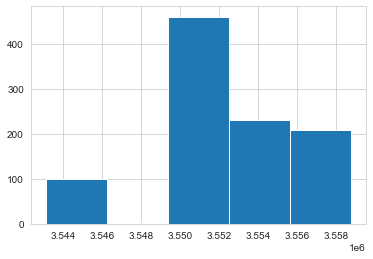

In [219]:
# Command to plot histogram
plt.hist(cost_vec, bins = 5)

<AxesSubplot:ylabel='Density'>

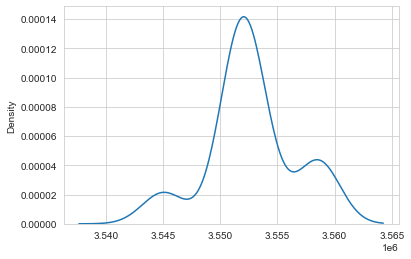

In [220]:
# Command to plot probability density curve
sns.set_style('whitegrid')
sns.kdeplot(cost_vec, bw_method=0.5)

In [222]:
# Detremine the mean and standard deviation of cost obtained from simulation
mean_cost = np.mean(cost_vec)
stdev_cost = statistics.stdev(cost_vec)
print("The cost distribution is found to have a mean of ", mean_cost,"dollars"," with a standard devaition of ", stdev_cost, "dollars")

The cost distribution is found to have a mean of  3552699.8504545535 dollars  with a standard devaition of  3679.5937741177363 dollars


In [223]:
# For 95% confidence level
conf_level = 0.05

# Using SciPy ppf method to generate values for the
# inverse cumulative distribution function to a normal distribution
# Plugging in the mean, standard deviation of our cost
# as calculated above

cutoff1 = norm.ppf(conf_level, mean_cost, stdev_cost)

In [224]:
# calculating VaR for cost
var_1d1 = initial_cost - cutoff1 
print("The VaR for an initial cost from first case(", initial_cost,"dollars) is", var_1d1)

The VaR for an initial cost from first case( 5370696.833046886 dollars) is 1824049.375757398


In [225]:
# 3.2 b. second section of extra credit part
# Creating a power generation dictionary from the first optimization problem of the project
# has the following format ((generator index),x Watts of power)
power_gen = dict(zip(generators,pg1))
# Separating non-wind and wind generators
# First extracting a separate dictionary of non-wind generators
mydict = power_gen
power_nonwind = []
for x in list(mydict.items())[0:362]:
    power_nonwind.append(x)

In [226]:
power_nonwind = dict(power_nonwind)
# Now within non-wind creating a dictinction between those running at full efficiency and those at less than 100% efficiency
# power_nonwind_max is a vector containing all generators at max efficiency
power_nonwind_max = []
# power_nonwind_norm is a vector containing all generators at less than 100% efficiency
power_nonwind_norm = []

# Looping to get the above two vectors from the power generation dictionary of the first run based on the condition
for a in generators[0:362]:
    if power_nonwind[a] == pmax[a]:
        power_nonwind_max.append(a)
    else:
        power_nonwind_norm.append(a)

# Finally getting 2 separate lists i.e. of non wind generators operating at max efficiency and a list of all others including wind generators
# To be used in the constraints
power_nonwind_max = list(power_nonwind_max)
power_other = [x for x in generators if x not in power_nonwind_max]

In [227]:
m2 = gp.Model("Real_Energy_Markets")

d = dict(zip(buses,buses_file[" load"]))
x = dict(zip(flows,branches_file["x"]))
u = dict(zip(flows,branches_file["u"]))

pmax = dict(zip(generators,generators_file["pmax"]))
sig = dict(zip(generators,generators_file["sigma"]))


#Decision Variables
power_gen_last = m2.addVars(generators, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'), name="Pg")
power_flow_last = m2.addVars(flows, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'), name="Pf")
Theta_last = m2.addVars(buses, vtype=GRB.CONTINUOUS, lb = -float('inf'), ub = float('inf'),name="Theta")
Shed_last = m2.addVars(buses, vtype=GRB.CONTINUOUS, lb = 0, ub = float('inf'),name="Shed")

#Constraints
#Balance
m2.addConstrs((power_flow_last.sum('*',i,"*") - power_flow_last.sum("*","*",i) - power_gen_last.sum("*",i) - Shed_last[i] ==  - d[i] for i in buses), name="Flow_conservation")
#Power Flow and Capacity
m2.addConstrs((power_flow_last[i] - (1/x[i])*Theta_last[i[1]] + (1/x[i])*Theta_last[i[2]] == 0 for i in flows), name="Power Flow")
m2.addConstrs((power_flow_last[a] <= u[a] for a in flows), name="Power limit")
m2.addConstrs((power_flow_last[a] >= -u[a] for a in flows), name="Power limit")
# Shed
m2.addConstrs((Shed_last[v] <= d[v] for v in buses), name="Shed limit")
# Power
# For all low efficiency generators and wind generators, they operate at the same capacity as before
m2.addConstrs((power_gen_last[v] <= pmax[v] for v in power_other), name="Power Generation limit")
# For max effieciency, the capacity has been doubled as seen in constraint
m2.addConstrs((power_gen_last[v] <= 2*pmax[v] for v in power_nonwind_max), name="Power Generation limit")

# Objective
m2.setObjective(quicksum(power_gen_last[e]*sig[e] for e in generators) +  quicksum(1000000*Shed_last[e] for e in buses), GRB.MINIMIZE)
# Optimize
m2.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (mac64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 10632 rows, 6226 columns and 19839 nonzeros
Model fingerprint: 0x7a9fc2fe
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [4e+02, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-04, 3e+01]
Presolve removed 9491 rows and 3662 columns
Presolve time: 0.04s
Presolved: 1141 rows, 2564 columns, 6878 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
    1020    4.5188689e+05   0.000000e+00   0.000000e+00      0s

Solved in 1020 iterations and 0.20 seconds
Optimal objective  4.518868896e+05


In [231]:
obj1 = m.getObjective()
obj2 = m2.getObjective()
print("The optimal objective now reduces to ", obj2.getValue(),"which is lower than the previous objective by ", obj1.getValue() - obj2.getValue())

# getting duals for power balance and converting to pi
dual = []
for c in m2.getConstrs():
    dual.append(c.pi)   
dual = np.array(dual[0:1814])
pi = - dual
pi = dict(zip(buses, pi))

# Getting the shed values from the above optimization model
Shed_vec = []
for v in Shed_last.values():
    Shed_vec.append(v.X)
Shed_vec = dict(zip(buses, Shed_vec))

# Calculating cost for the last case
cost = quicksum(pi[i]*d[i] - pi[i]*Shed_vec[i] for i in buses)
initial_cost1 = cost.getValue()
print("The cost now reduces to ", initial_cost1,"which is lower than the previous cost by ", initial_cost - initial_cost1)


The optimal objective now reduces to  451886.88957368274 which is lower than the previous objective by  156696.19600838615
The cost now reduces to  4890704.670985169 which is lower than the previous cost by  479992.16206171736


In [233]:
# calculating VaR for cost
var_1d2 = initial_cost1 - cutoff1 
print("The VaR for an initial cost from second case(", initial_cost1,"dollars) is", var_1d2)
print("Yes, the VaR decreases and that too by", var_1d1 - var_1d2)

The VaR for an initial cost from second case( 4890704.670985169 dollars) is 1344057.2136956807
Yes, the VaR decreases and that too by 479992.16206171736
